In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

In [121]:
# Uploading data
booking = pd.read_csv("bookings.txt", sep=",")

# Data cleaning and preparation

In [122]:
booking.dtypes

# Checking missing values
missing_counts = booking.isnull().sum()
cols_with_missing = missing_counts[missing_counts > 0]

if len(cols_with_missing) == 0:
    print("All columns have complete data: no missing n/A")
else:
    print("Columns with missing values:")
    print(cols_with_missing)

# Summary of each column
booking.describe(include='all')

All columns have complete data: no missing n/A


,hotel,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,booking_changes,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,canceled
count,5000,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000,5000,5000,5000,5000,5000,5000.000000,5000,5000,5000.000000,5000.000000,5000.000000,5000.000000
unique,2,12,NaN,NaN,NaN,NaN,NaN,5,90,7,4,8,10,NaN,3,4,NaN,NaN,NaN,NaN
top,City Hotel,August,NaN,NaN,NaN,NaN,NaN,BB,PRT,Online TA,TA/TO,A,A,NaN,No Deposit,Transient,NaN,NaN,NaN,NaN
freq,3258,585,NaN,NaN,NaN,NaN,NaN,3807,2048,2347,4065,3551,3068,NaN,4396,3725,NaN,NaN,NaN,NaN
mean,NaN,NaN,27.061800,15.708600,0.906600,2.489800,1.863000,NaN,NaN,NaN,NaN,NaN,NaN,0.219000,NaN,NaN,102.669692,0.065000,0.574200,0.365200
std,NaN,NaN,13.531585,8.791311,0.971012,1.826955,0.482781,NaN,NaN,NaN,NaN,NaN,NaN,0.673446,NaN,NaN,48.879693,0.248168,0.793864,0.481534
min,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,16.000000,8.000000,0.000000,1.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,70.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,27.000000,16.000000,1.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,94.500000,0.000000,0.000000,0.000000
75%,NaN,NaN,38.000000,23.000000,2.000000,3.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,126.000000,0.000000,1.000000,1.000000


In [123]:
# Removing invalid entries
booking = booking[booking['adr'] > 0]
booking = booking[booking['adults'] > 0]

In [124]:
# Creating variables
booking['total_nights'] = booking['stays_in_weekend_nights'] + booking['stays_in_week_nights']

# Modifying variables
booking['meal'] = booking['meal'].replace({'BB': 'Bed & Breakfast', 'FB': 'Full Board', 'HB': 'Half Board', 'SC': 'No Meal', 'Undefined': 'No Meal'})

In [125]:
# Formatting arrival date
# Choose 2024 = the most recent leap year
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
booking['month_num'] = booking['arrival_date_month'].map(month_map)

booking['arrival_date'] = pd.to_datetime({
    'year': 2024,
    'month': booking['month_num'],
    'day': booking['arrival_date_day_of_month']
}, errors='coerce')

# Extract day name (Monday, Tuesday, etc.)
booking['day_name'] = booking['arrival_date'].dt.day_name()

# Formatting leaving date
booking['departure_date'] = booking['arrival_date'] + pd.to_timedelta(booking['total_nights'], unit='D')

# Part 1. Introduction: Overall cancellation rate

In [126]:
# Proportion of cancelled bookings
cancellation_rate = booking['canceled'].mean()
print(f"Overall cancellation rate: {cancellation_rate:.2%}")

# Total revenues
revenue = booking['adr'].sum()
print(f"Total revenue from bookings: ${revenue:,.2f}")

# Amount of money lost due to cancellations
lost_revenue = booking.loc[(booking['canceled'] == 1), 'adr'].sum()
print(f"Total lost revenue due to cancellations (without accounting for deposits): ${lost_revenue:,.2f}")

# Share of lost revenue due to cancellations
lost_revenue_share = lost_revenue / revenue
print(f"Share of lost revenue due to cancellations: {lost_revenue_share:.2%}")

Overall cancellation rate: 36.86%
Total revenue from bookings: $512,235.25
Total lost revenue due to cancellations (without accounting for deposits): $195,721.27
Share of lost revenue due to cancellations: 38.21%


# Part 2. Distribution of variables: Booking patterns

In [127]:
# Table: Overall booking statistics 
total_bookings = len(booking)
total_clients = booking['adults'].sum()

booking_stats = pd.DataFrame({
    'Metric': ['Total bookings', 'Total clients', 'Total revenue'],
    'Value': [
        total_bookings,
        total_clients,
        f"${revenue:,.0f}"
    ]
})
booking_stats

,Metric,Value
0,Total bookings,4918
1,Total clients,9221
2,Total revenue,"$512,235"


In [128]:
# Distribution of numerical variables
num_vars = ['adults', 'total_nights', 'required_car_parking_spaces', 'total_of_special_requests', 'booking_changes', 'adr']
var_names = [
    'Number of adults',
    'Total number of nights',
    'Required car parking spaces',
    'Total number of special requests',
    'Number of booking changes',
    'Daily average room price'
]

num_summary = pd.DataFrame({
    'Variable': var_names,
    'Mean': booking[num_vars].mean(),
    'Median': booking[num_vars].median(),
    'Min': booking[num_vars].min(),
    'Max': booking[num_vars].max()
}).round(2)
num_summary

,Variable,Mean,Median,Min,Max
adults,Number of adults,1.87,2.0,1.0,4.0
total_nights,Total number of nights,3.42,3.0,1.0,28.0
required_car_parking_spaces,Required car parking spaces,0.07,0.0,0.0,2.0
total_of_special_requests,Total number of special requests,0.57,0.0,0.0,5.0
booking_changes,Number of booking changes,0.21,0.0,0.0,18.0
adr,Daily average room price,104.16,95.0,4.0,382.0


In [129]:
# Distribution of categorical variables
cat_vars = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'customer_type', 'country', 'deposit_type']
for var in cat_vars:
    print(f"\nDistribution of {var}:")
    print(booking[var].value_counts(normalize=True).round(3)) 



Distribution of hotel:
hotel
City Hotel      0.651
Resort Hotel    0.349
Name: proportion, dtype: float64

Distribution of meal:
meal
Bed & Breakfast    0.759
Half Board         0.132
No Meal            0.100
Full Board         0.008
Name: proportion, dtype: float64

Distribution of market_segment:
market_segment
Online TA        0.473
Offline TA/TO    0.199
Groups           0.175
Direct           0.109
Corporate        0.041
Aviation         0.002
Complementary    0.001
Name: proportion, dtype: float64

Distribution of distribution_channel:
distribution_channel
TA/TO        0.820
Direct       0.126
Corporate    0.052
GDS          0.002
Name: proportion, dtype: float64

Distribution of customer_type:
customer_type
Transient          0.746
Transient-Party    0.216
Contract           0.035
Group              0.004
Name: proportion, dtype: float64

Distribution of country:
country
PRT    0.405
GBR    0.106
FRA    0.083
ESP    0.079
DEU    0.060
       ...  
CRI    0.000
SAU    0.000
BLR 

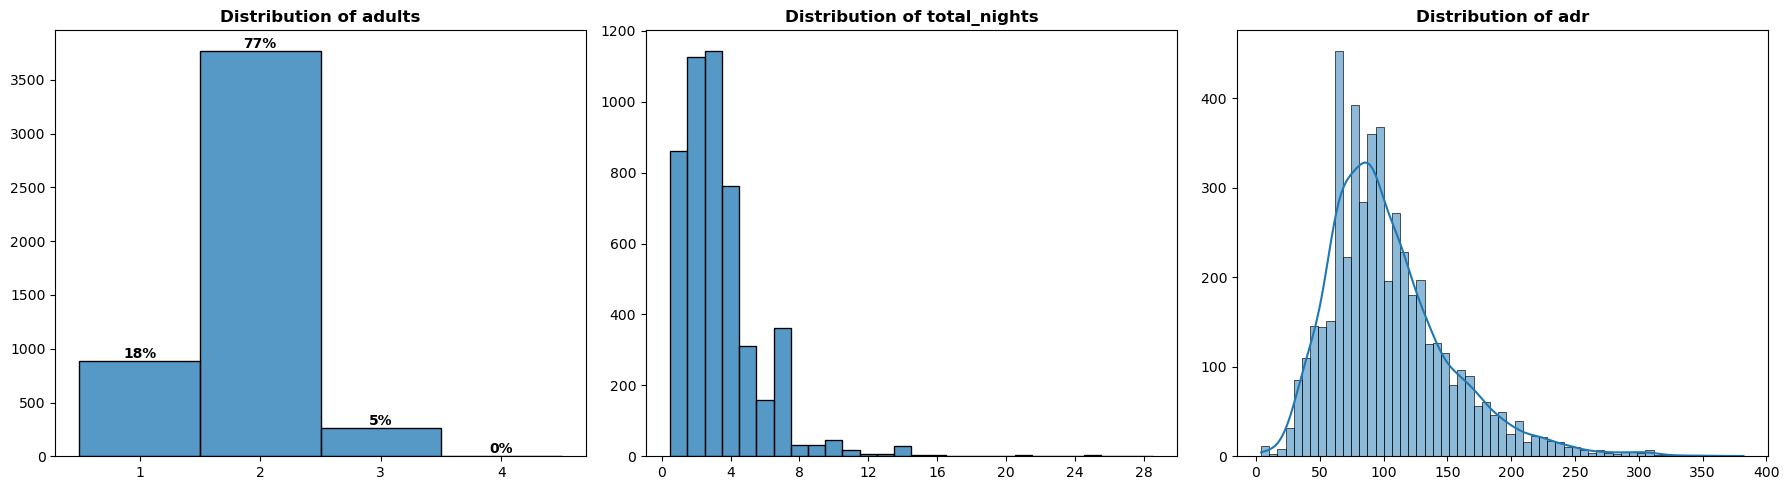

In [130]:
# Graphical representation of numerical variables
from matplotlib.ticker import MaxNLocator

num_vars = ['adults', 'total_nights', 'adr']
booking[num_vars] = booking[num_vars].astype(int)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, var in enumerate(num_vars):
    min_val = booking[var].min()
    max_val = booking[var].max()
    
    # Use appropriate number of bins based on the range
    if max_val - min_val <= 30:
        bins = range(min_val, max_val + 2)
        discrete = True
        kde = False
    else:
        bins = 'auto'
        discrete = False
        kde = True
    
    sns.histplot(data=booking, x=var, bins=bins, discrete=discrete, ax=axes[i], kde=kde)
    
    axes[i].set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='x')
    
    # Force x-axis to show only integer values
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

    if var == 'adults':
        total = len(booking)
        for p in axes[i].patches:
            height = p.get_height()
            pct = round((height / total) * 100)
            axes[i].annotate(f'{pct}%', 
                             (p.get_x() + p.get_width()/2., height),
                             ha='center', va='bottom',
                             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

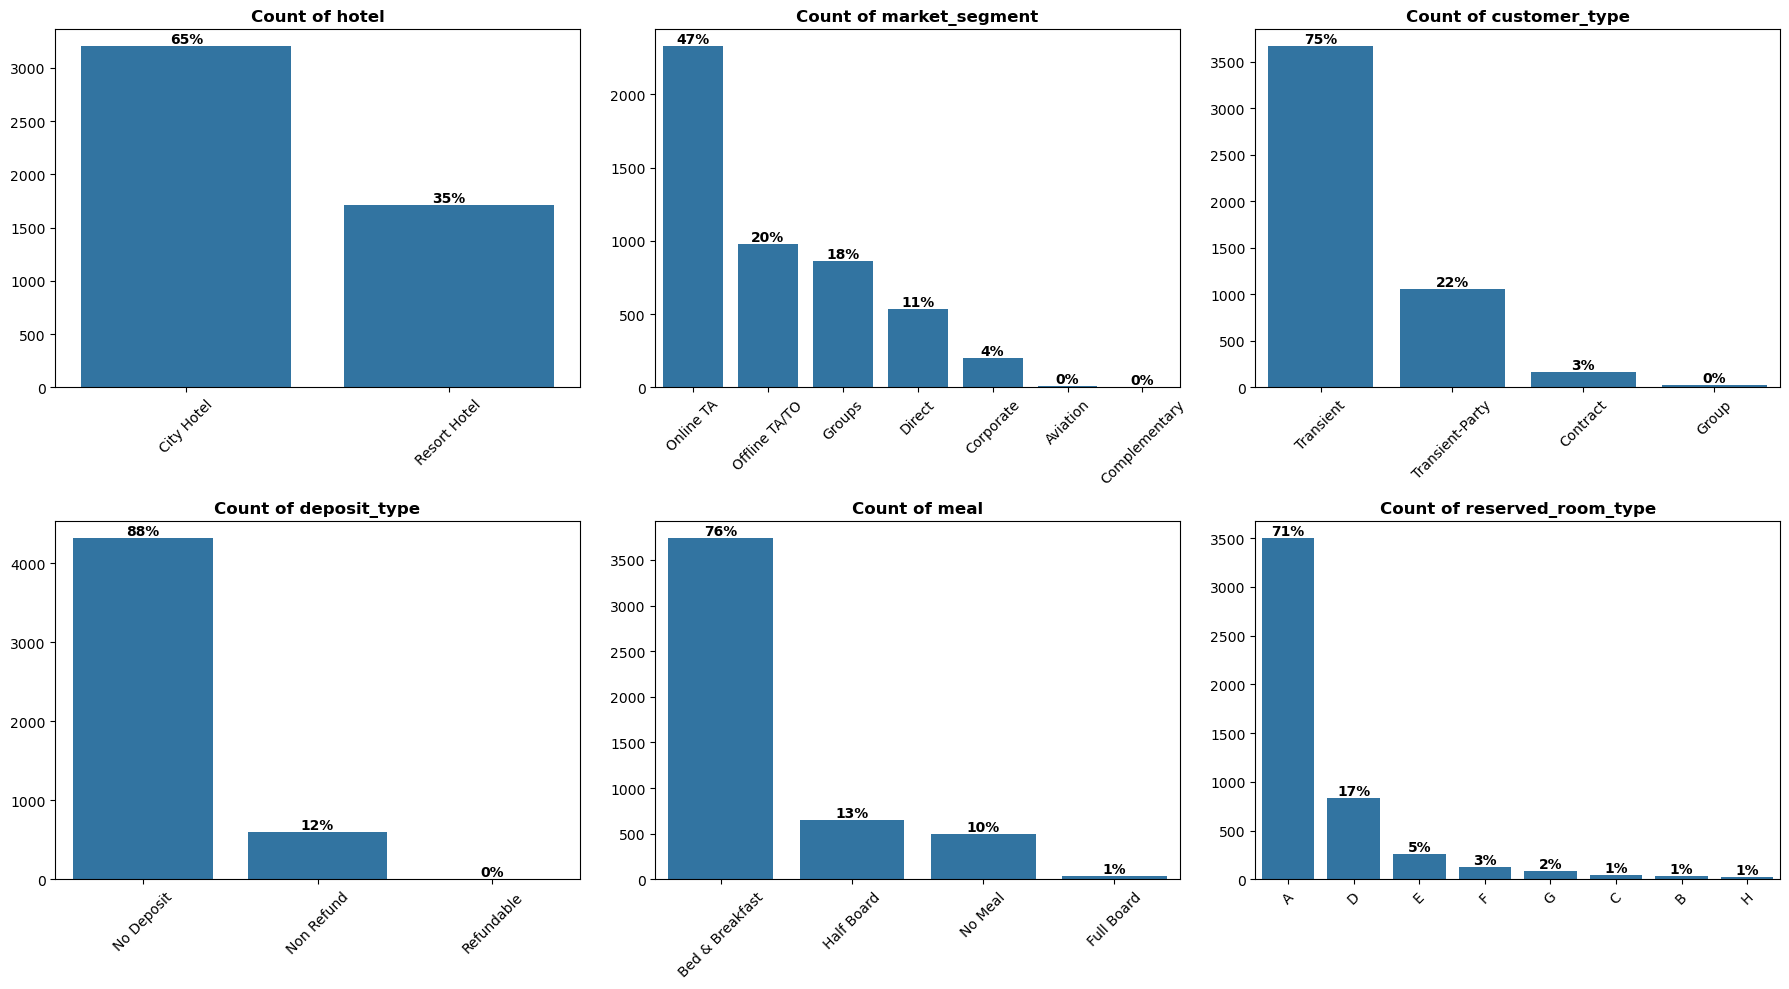

In [131]:
# Graphical representation of categorical variables
# We select market_segment which mostly includes ditrsibution channel. 
cat_vars = ['hotel', 'market_segment', 'customer_type', 'deposit_type', 'meal', 'reserved_room_type']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(cat_vars):
    ax = axes[i]
    
    sns.countplot(
        data=booking,
        x=var,
        order=booking[var].value_counts().index,
        ax=ax
    )
    
    ax.set_title(f'Count of {var}', fontsize=12, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', rotation=45)
    
    total = len(booking)
    for p in ax.patches:
        height = p.get_height()
        pct = round((height / total) * 100)
        ax.annotate(f'{pct}%', 
                    (p.get_x() + p.get_width()/2., height),
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Seasonality in bookings

In [132]:
# Daily bookings
daily_bookings = booking.groupby('arrival_date').size().reset_index(name='num_bookings')

# Weekly bookings
weekly_bookings = booking.groupby('arrival_date_week_number').size().reset_index(name='num_bookings')
weekly_bookings['num_bookings'] = weekly_bookings['num_bookings'] / 7  # average per day

# Monthly bookings
month_days = {
    'January': 31, 'February': 28, 'March': 31, 'April': 30,
    'May': 31, 'June': 30, 'July': 31, 'August': 31,
    'September': 30, 'October': 31, 'November': 30, 'December': 31
}

monthly_bookings = booking.groupby('arrival_date_month').size().reset_index(name='num_bookings')
monthly_bookings['num_bookings'] = monthly_bookings.apply(lambda row: row['num_bookings'] / month_days[row['arrival_date_month']], axis=1)

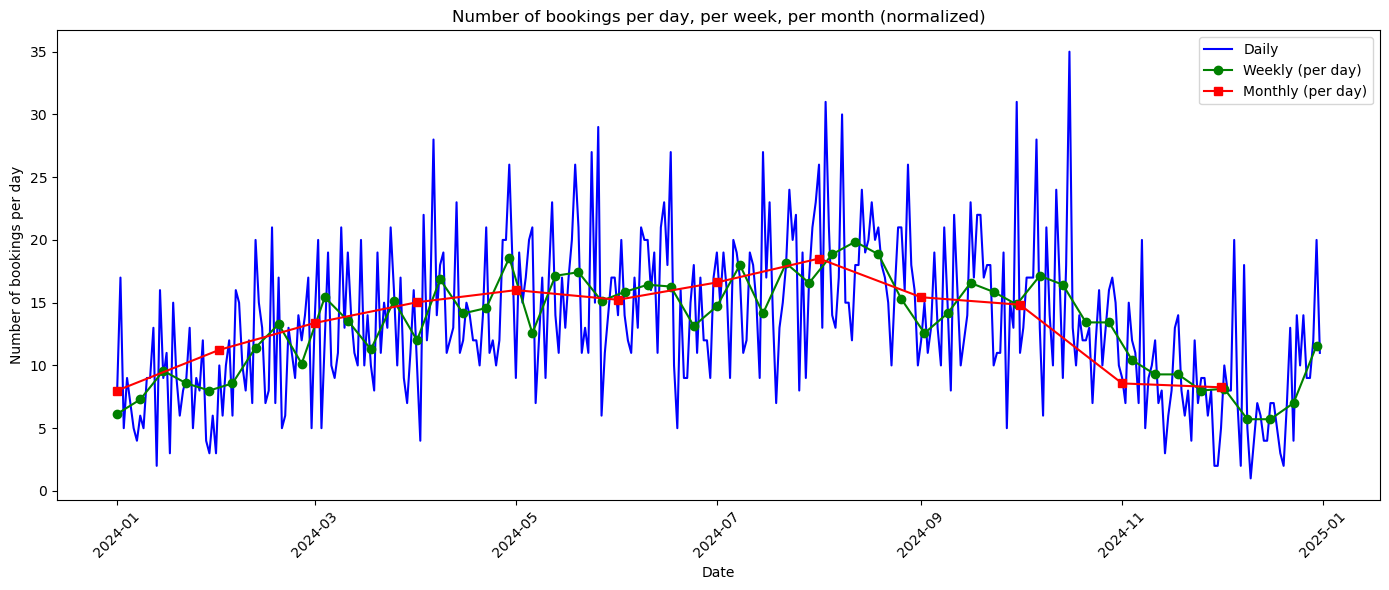

In [133]:
import calendar
year = 2024  # leap year

# Daily bookings
daily_bookings = booking.groupby('arrival_date').size().reset_index(name='num_bookings')

# Weekly bookings
weekly_bookings = booking.groupby('arrival_date_week_number').size().reset_index(name='num_bookings')
weekly_bookings['num_bookings'] = weekly_bookings['num_bookings'] / 7  # per day
weekly_bookings['week_start_date'] = weekly_bookings['arrival_date_week_number'].apply(
    lambda w: pd.Timestamp(f'{year}-01-01') + pd.to_timedelta((w-1)*7, unit='d')
)

# Monthly bookings
monthly_bookings = booking.groupby('month_num').size().reset_index(name='num_bookings')
monthly_bookings['num_bookings'] = monthly_bookings.apply(
    lambda row: row['num_bookings'] / calendar.monthrange(year, row['month_num'])[1], axis=1
)
monthly_bookings['month_start_date'] = monthly_bookings['month_num'].apply(
    lambda m: pd.Timestamp(f'{year}-{m:02d}-01')
)

# Graphique
plt.figure(figsize=(14,6))
plt.plot(daily_bookings['arrival_date'], daily_bookings['num_bookings'], label='Daily', color='blue')
plt.plot(weekly_bookings['week_start_date'], weekly_bookings['num_bookings'], label='Weekly (per day)', color='green', marker='o')
plt.plot(monthly_bookings['month_start_date'], monthly_bookings['num_bookings'], label='Monthly (per day)', color='red', marker='s')

plt.xlabel('Date')
plt.ylabel('Number of bookings per day')
plt.title('Number of bookings per day, per week, per month (normalized)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

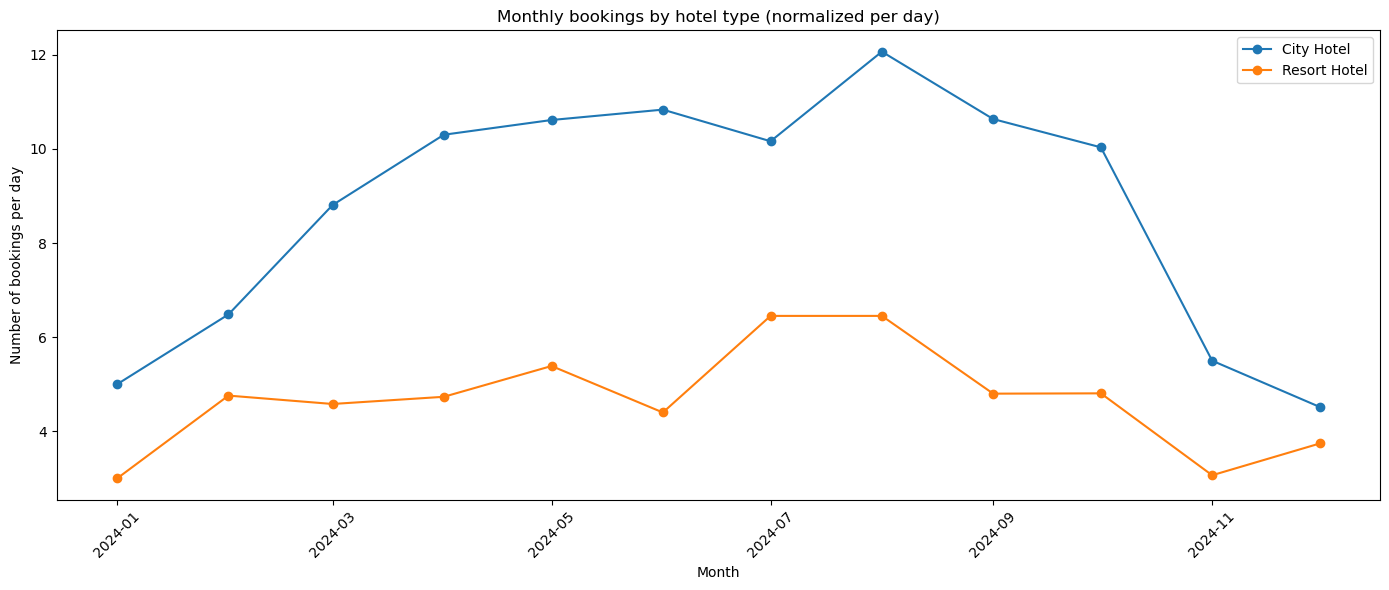

In [134]:
# Differentiating by hotel type

monthly_by_hotel = booking.groupby(['hotel', 'month_num']).size().reset_index(name='num_bookings')

monthly_by_hotel['num_bookings'] = monthly_by_hotel.apply(
    lambda row: row['num_bookings'] / calendar.monthrange(year, row['month_num'])[1],
    axis=1
)

monthly_by_hotel['month_start_date'] = monthly_by_hotel['month_num'].apply(
    lambda m: pd.Timestamp(f'{year}-{m:02d}-01')
)

# Plot
plt.figure(figsize=(14,6))

for hotel_type in monthly_by_hotel['hotel'].unique():
    data = monthly_by_hotel[monthly_by_hotel['hotel'] == hotel_type]
    plt.plot(data['month_start_date'], data['num_bookings'], marker='o', label=hotel_type)

plt.xlabel('Month')
plt.ylabel('Number of bookings per day')
plt.title('Monthly bookings by hotel type (normalized per day)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


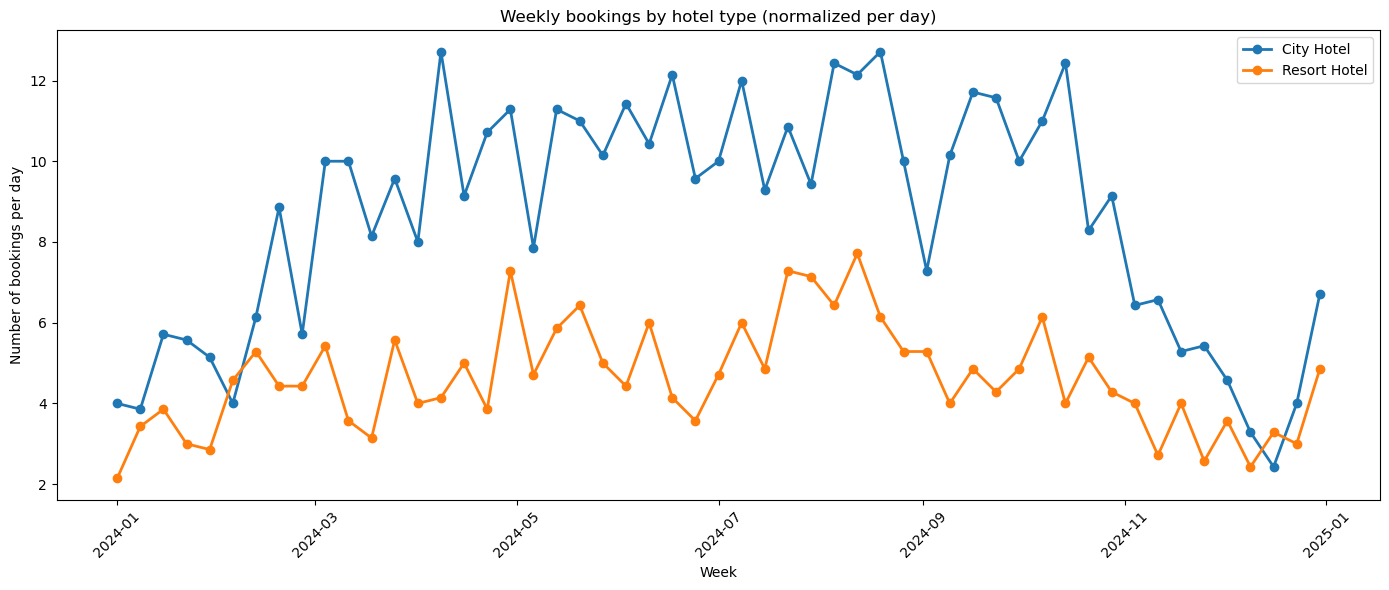

In [135]:
# Weekly bookings by hotel type

weekly_by_hotel = booking.groupby(['hotel', 'arrival_date_week_number']).size().reset_index(name='num_bookings')

weekly_by_hotel['num_bookings'] = weekly_by_hotel['num_bookings'] / 7  # per day
weekly_by_hotel['week_start_date'] = weekly_by_hotel['arrival_date_week_number'].apply(
    lambda w: pd.Timestamp(f'{year}-01-01') + pd.to_timedelta((w-1)*7, unit='d')
)

# Plot
plt.figure(figsize=(14,6))

for hotel_type in weekly_by_hotel['hotel'].unique():
    data = weekly_by_hotel[weekly_by_hotel['hotel'] == hotel_type]
    plt.plot(data['week_start_date'], data['num_bookings'], marker='o', label=hotel_type, linewidth=2)

plt.xlabel('Week')
plt.ylabel('Number of bookings per day')
plt.title('Weekly bookings by hotel type (normalized per day)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Part 3: Analysis of cancellation rate

# Seasonality in cancellation rate

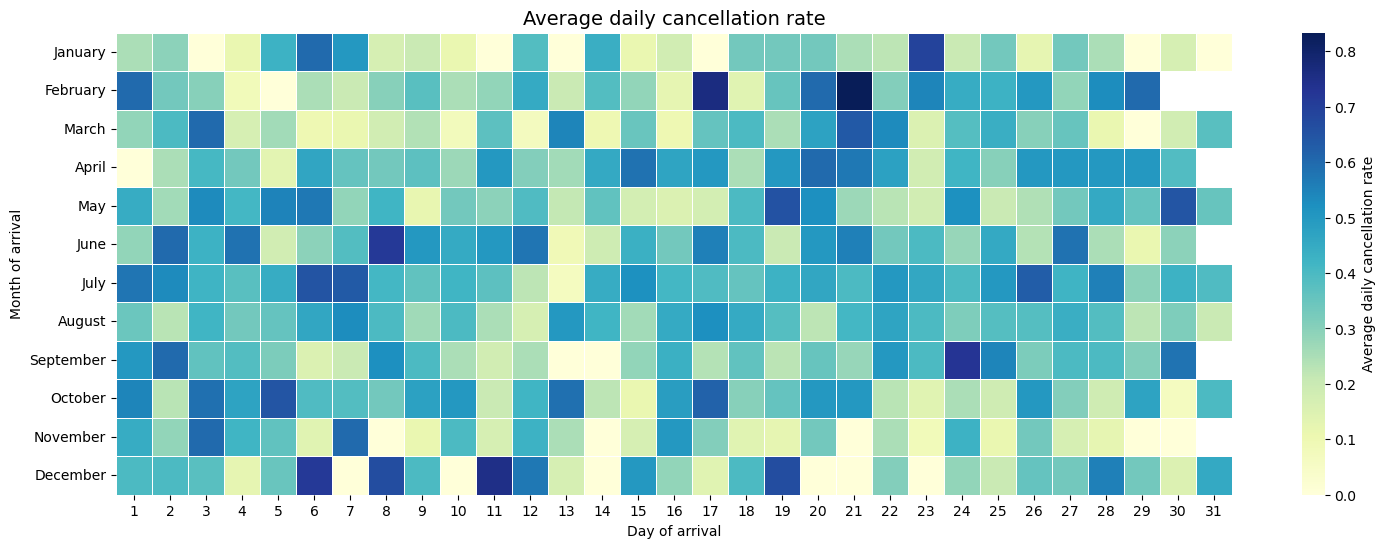

In [136]:
# Cancellation rate per day
cancellation_rate = (
    booking.groupby(['arrival_date_month', 'arrival_date_day_of_month'])['canceled']
    .mean()
    .reset_index()
)

month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

cancellation_rate['arrival_date_month'] = pd.Categorical(
    cancellation_rate['arrival_date_month'],
    categories=month_order,
    ordered=True
)

heatmap_data = cancellation_rate.pivot(
    index='arrival_date_month',
    columns='arrival_date_day_of_month',
    values='canceled'
)

plt.figure(figsize=(18, 6))
sns.heatmap(
    heatmap_data,
    linewidths=0.5,
    cbar_kws={'label': 'Average daily cancellation rate'},
    cmap='YlGnBu',
)
plt.title("Average daily cancellation rate", fontsize=14)
plt.xlabel("Day of arrival")
plt.ylabel("Month of arrival")
plt.show()

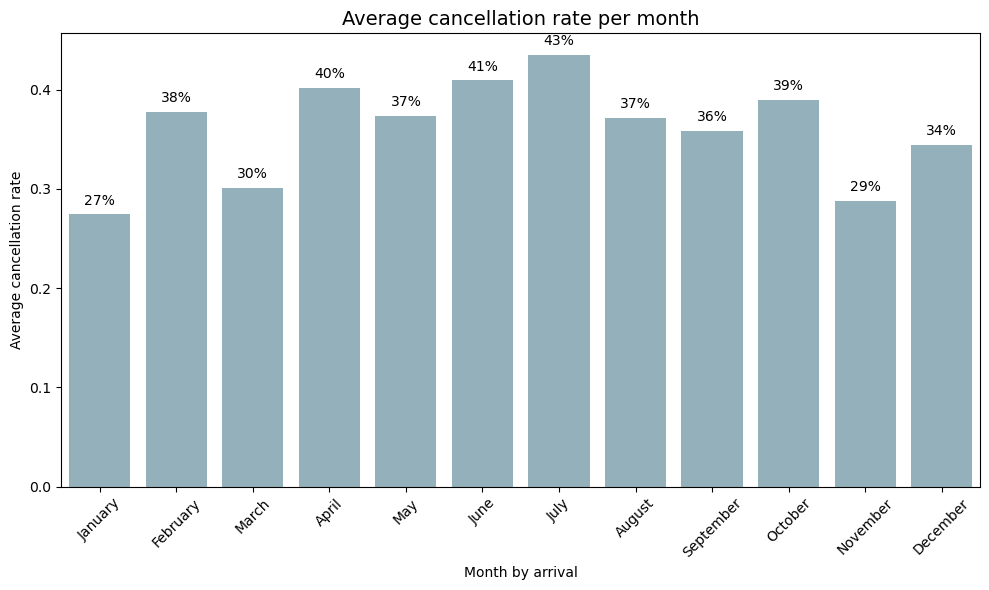

In [137]:
# Cancellation rate per month
cancellation_by_month = (
    booking.groupby('arrival_date_month')['canceled']
    .mean()
    .reset_index()
)

cancellation_by_month['arrival_date_month'] = pd.Categorical(
    cancellation_by_month['arrival_date_month'],
    categories=month_order,
    ordered=True
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=cancellation_by_month,
    x='arrival_date_month',
    y='canceled',
    color="#8EB4C1"
)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 0.01,
        f"{p.get_height():.0%}",
        ha='center'
    )

plt.title("Average cancellation rate per month", fontsize=14)
plt.xlabel("Month by arrival")
plt.ylabel("Average cancellation rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



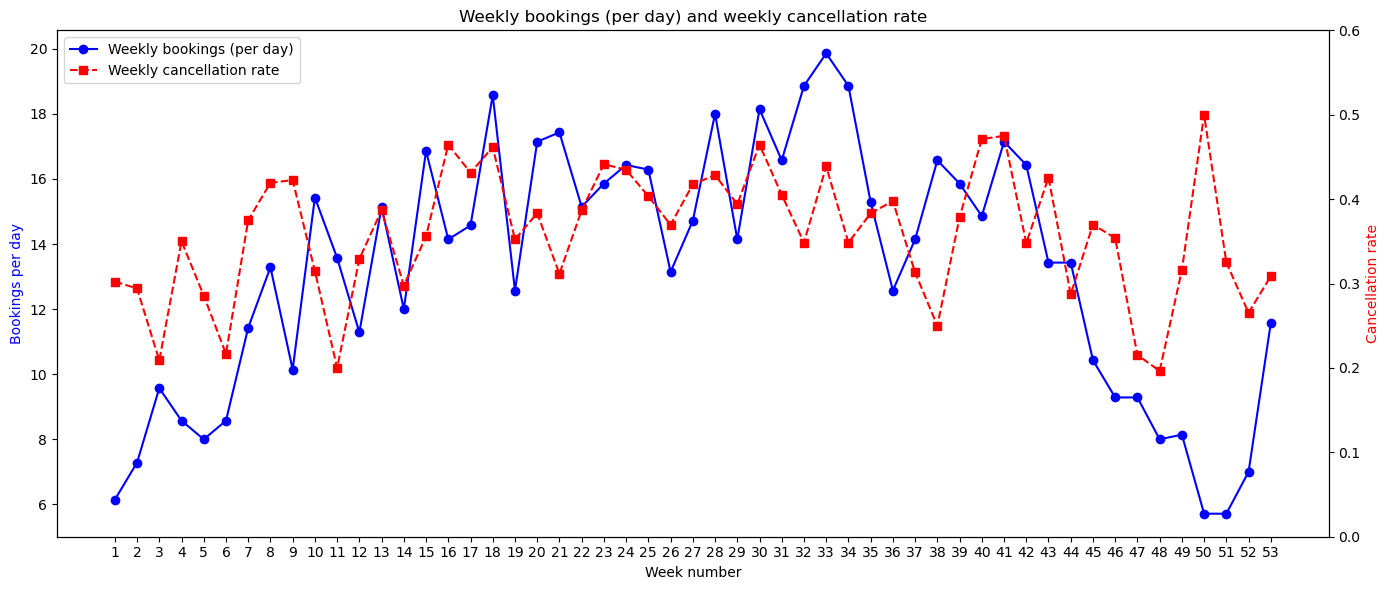

In [138]:
# Graphique: Weekly bookings and cancellation rate

# Weekly cancellation rate
weekly_cancel = booking.groupby('arrival_date_week_number')['canceled'].mean().reset_index(name='cancel_rate')
weekly = weekly_bookings.merge(weekly_cancel, on='arrival_date_week_number')

# Plot
plt.figure(figsize=(14,6))

line1, = plt.plot(
    weekly['arrival_date_week_number'], 
    weekly['num_bookings'], 
    marker='o', 
    color='blue', 
    label='Weekly bookings (per day)'
)

plt.xlabel("Week number")
plt.ylabel("Bookings per day", color='blue')
plt.xticks(weekly['arrival_date_week_number'])

ax2 = plt.twinx()

line2, = ax2.plot(
    weekly['arrival_date_week_number'], 
    weekly['cancel_rate'], 
    marker='s', 
    linestyle='--', 
    color='red', 
    label='Weekly cancellation rate'
)

ax2.set_ylabel("Cancellation rate", color='red')
ax2.set_ylim(0, weekly['cancel_rate'].max() * 1.2)

plt.title("Weekly bookings (per day) and weekly cancellation rate")
plt.tight_layout()


plt.legend(handles=[line1, line2], loc='upper left')

plt.show()


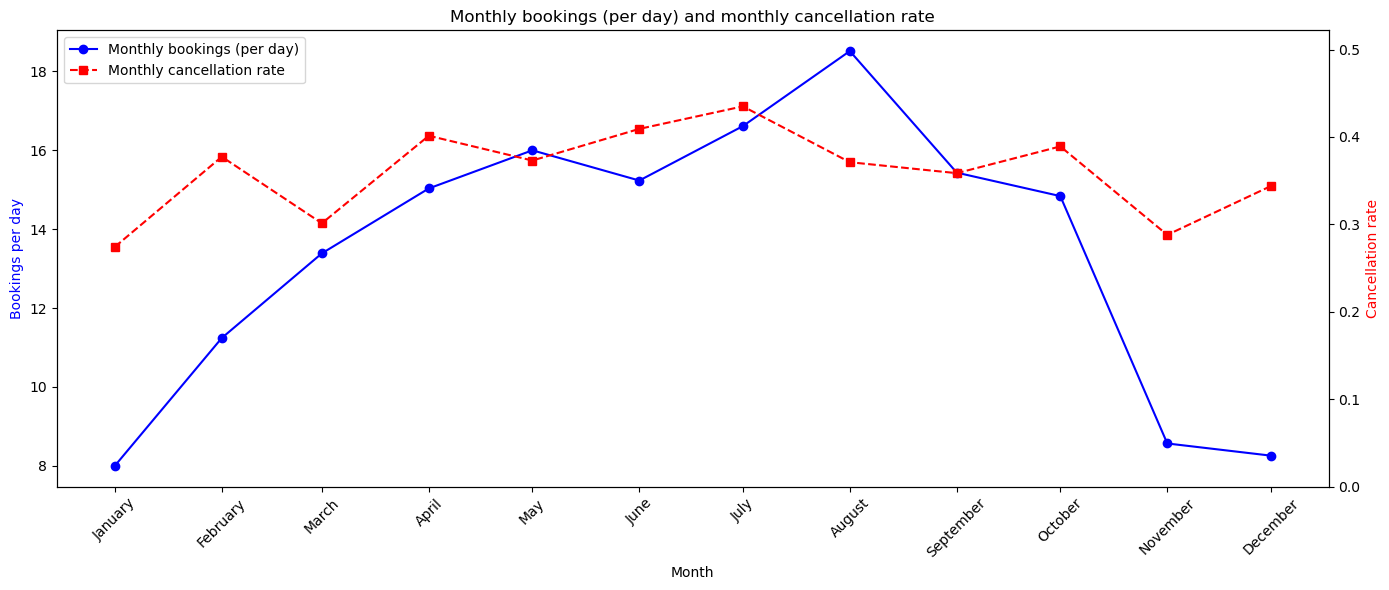

In [139]:
# Graphique: Monthy bookings and cancellation rate

monthly_cancel = (
    booking.groupby('month_num')['canceled']
    .mean()
    .reset_index(name='cancel_rate')
)
monthly = monthly_bookings.merge(monthly_cancel, on='month_num')

monthly['month_start'] = monthly['month_num'].apply(
    lambda m: pd.Timestamp(f"{year}-{m:02d}-01")
)

# Plot
plt.figure(figsize=(14,6))

line1, = plt.plot(
    monthly['month_start'],
    monthly['num_bookings'],
    marker='o',
    color='blue',
    label='Monthly bookings (per day)'
)

plt.xlabel("Month")
plt.ylabel("Bookings per day", color='blue')

plt.xticks(
    monthly['month_start'],
    [calendar.month_name[m] for m in monthly['month_num']],
    rotation=45
)

ax2 = plt.twinx()

line2, = ax2.plot(
    monthly['month_start'],
    monthly['cancel_rate'],
    marker='s',
    linestyle='--',
    color='red',
    label='Monthly cancellation rate'
)

ax2.set_ylabel("Cancellation rate", color='red')
ax2.set_ylim(0, monthly['cancel_rate'].max() * 1.2)

plt.title("Monthly bookings (per day) and monthly cancellation rate")
plt.tight_layout()

plt.legend(handles=[line1, line2], loc='upper left')

plt.show()


# Statistics of cancellation rate with other variables

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

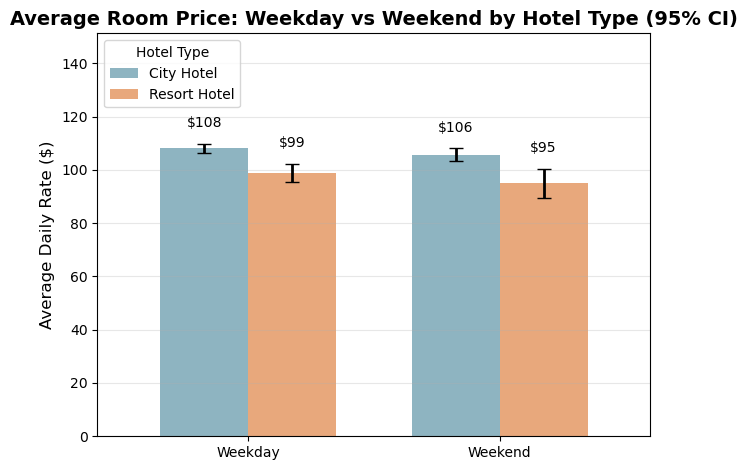

In [140]:
# Average price: Weekdays vs Weekend by hotel type

# Create weekday/weekend classification
booking['is_weekend'] = booking['day_name'].isin(['Saturday', 'Sunday'])
booking['day_type'] = booking['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

# Calculate metrics by day type and hotel with confidence intervals
from scipy import stats

weekday_hotel_stats = booking.groupby(['day_type', 'hotel']).agg({
    'adr': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
weekday_hotel_stats.columns = ['day_type', 'hotel', 'mean', 'std', 'count']

# Calculate 95% confidence interval
confidence_level = 0.95
weekday_hotel_stats['ci'] = weekday_hotel_stats.apply(
    lambda row: stats.t.ppf((1 + confidence_level) / 2, row['count'] - 1) * row['std'] / np.sqrt(row['count']),
    axis=1
)

# Plot: Average price by weekday/weekend and hotel
plt.figure(figsize=(10, 6))

# Prepare data for plotting
weekday_pivot_mean = weekday_hotel_stats.pivot(index='day_type', columns='hotel', values='mean')
weekday_pivot_mean = weekday_pivot_mean.reindex(['Weekday', 'Weekend'])

weekday_pivot_ci = weekday_hotel_stats.pivot(index='day_type', columns='hotel', values='ci')
weekday_pivot_ci = weekday_pivot_ci.reindex(['Weekday', 'Weekend'])

# Create bar plot with error bars
ax = weekday_pivot_mean.plot(
    kind='bar', 
    color=['#8EB4C1', '#E8A87C'], 
    width=0.7,
    yerr=weekday_pivot_ci,
    capsize=5,
    error_kw={'linewidth': 2, 'ecolor': 'black'}
)

plt.title('Average Room Price: Weekday vs Weekend by Hotel Type (95% CI)', fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylim(0, weekday_pivot_mean.values.max() * 1.4)
plt.ylabel('Average Daily Rate ($)', fontsize=12)
plt.legend(title='Hotel Type', loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars (skip ErrorbarContainer objects)
for container in ax.containers:
    if hasattr(container, 'patches'):  # Only label bar containers, not errorbars
        ax.bar_label(container, fmt='$%.0f', padding=10)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

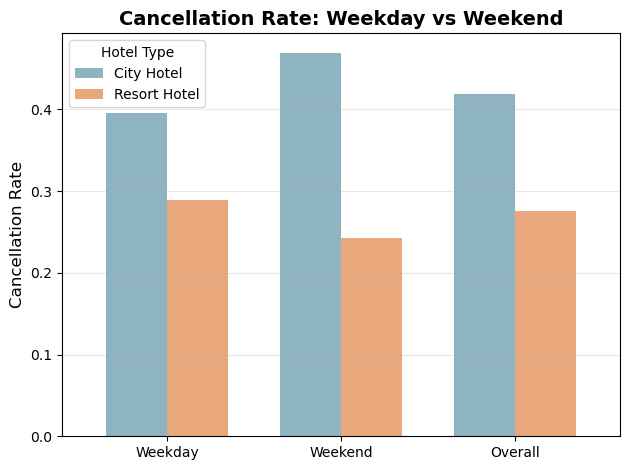

In [168]:
# Cancellation rate: Weekdays vs Weekend by hotel type

# Calculate cancellation metrics by day type and hotel
weekday_hotel_cancel = booking.groupby(['day_type', 'hotel'])['canceled'].mean().reset_index()

# Calculate overall cancellation rate by hotel (across all days)
overall_hotel_cancel = booking.groupby('hotel')['canceled'].mean()

# Create data for plotting with three groups
plot_data = pd.DataFrame({
    'Category': ['Weekday', 'Weekend', 'Overall'],
    'City Hotel': [
        weekday_hotel_cancel[(weekday_hotel_cancel['day_type'] == 'Weekday') & 
                             (weekday_hotel_cancel['hotel'] == 'City Hotel')]['canceled'].values[0],
        weekday_hotel_cancel[(weekday_hotel_cancel['day_type'] == 'Weekend') & 
                             (weekday_hotel_cancel['hotel'] == 'City Hotel')]['canceled'].values[0],
        overall_hotel_cancel['City Hotel']
    ],
    'Resort Hotel': [
        weekday_hotel_cancel[(weekday_hotel_cancel['day_type'] == 'Weekday') & 
                             (weekday_hotel_cancel['hotel'] == 'Resort Hotel')]['canceled'].values[0],
        weekday_hotel_cancel[(weekday_hotel_cancel['day_type'] == 'Weekend') & 
                             (weekday_hotel_cancel['hotel'] == 'Resort Hotel')]['canceled'].values[0],
        overall_hotel_cancel['Resort Hotel']
    ]
})

# Plot
plt.figure(figsize=(10, 6))
plot_data.set_index('Category')[['City Hotel', 'Resort Hotel']].plot(
    kind='bar', 
    color=['#8EB4C1', '#E8A87C'], 
    width=0.7
)

plt.title('Cancellation Rate: Weekday vs Weekend', fontsize=14, fontweight='bold')
plt.xlabel('', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.legend(title='Hotel Type', loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

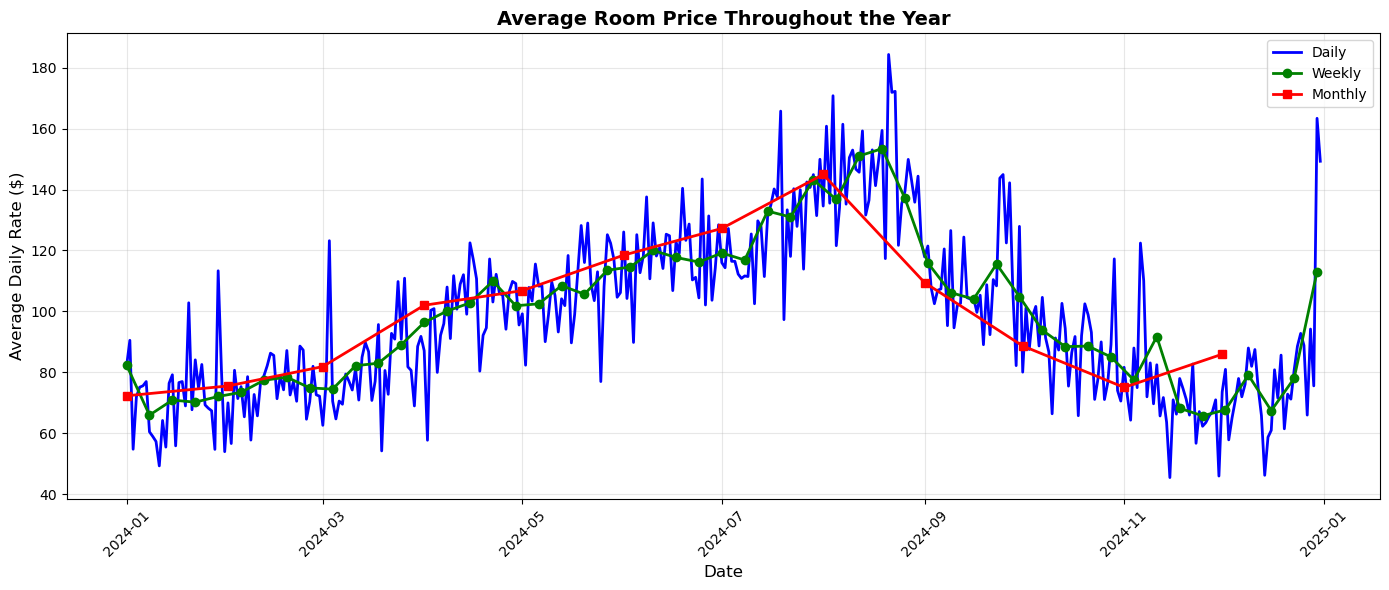

In [142]:
# Average room price (ADR) throughout the year

# Daily average price
price_by_date = booking.groupby('arrival_date')['adr'].mean().reset_index()

# Weekly average price
price_by_week = booking.groupby('arrival_date_week_number')['adr'].mean().reset_index()
price_by_week['week_start_date'] = price_by_week['arrival_date_week_number'].apply(
    lambda w: pd.Timestamp(f'{year}-01-01') + pd.to_timedelta((w-1)*7, unit='d')
)

# Monthly average price
price_by_month = booking.groupby('month_num')['adr'].mean().reset_index()
price_by_month['month_start_date'] = price_by_month['month_num'].apply(
    lambda m: pd.Timestamp(f'{year}-{m:02d}-01')
)

plt.figure(figsize=(14, 6))
plt.plot(price_by_date['arrival_date'], price_by_date['adr'], label='Daily', linewidth=2, color='blue')
plt.plot(price_by_week['week_start_date'], price_by_week['adr'], label='Weekly', linewidth=2, color='green', marker='o')
plt.plot(price_by_month['month_start_date'], price_by_month['adr'], label='Monthly', linewidth=2, color='red', marker='s')
plt.title('Average Room Price Throughout the Year', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Daily Rate ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

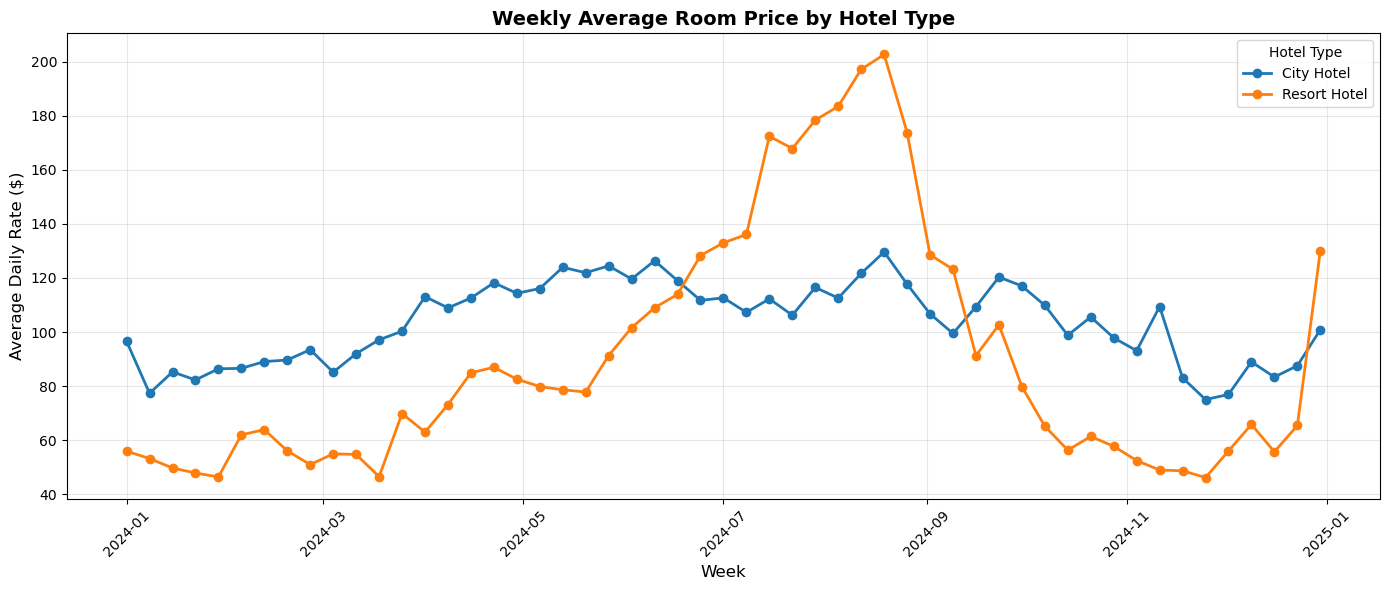

In [143]:
# Average price per week by hotel type

weekly_price_by_hotel = booking.groupby(['hotel', 'arrival_date_week_number'])['adr'].mean().reset_index()
weekly_price_by_hotel['week_start_date'] = weekly_price_by_hotel['arrival_date_week_number'].apply(
    lambda w: pd.Timestamp(f'{year}-01-01') + pd.to_timedelta((w-1)*7, unit='d')
)

plt.figure(figsize=(14, 6))

for hotel_type in weekly_price_by_hotel['hotel'].unique():
    data = weekly_price_by_hotel[weekly_price_by_hotel['hotel'] == hotel_type]
    plt.plot(data['week_start_date'], data['adr'], marker='o', label=hotel_type, linewidth=2)

plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Daily Rate ($)', fontsize=12)
plt.title('Weekly Average Room Price by Hotel Type', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Hotel Type')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

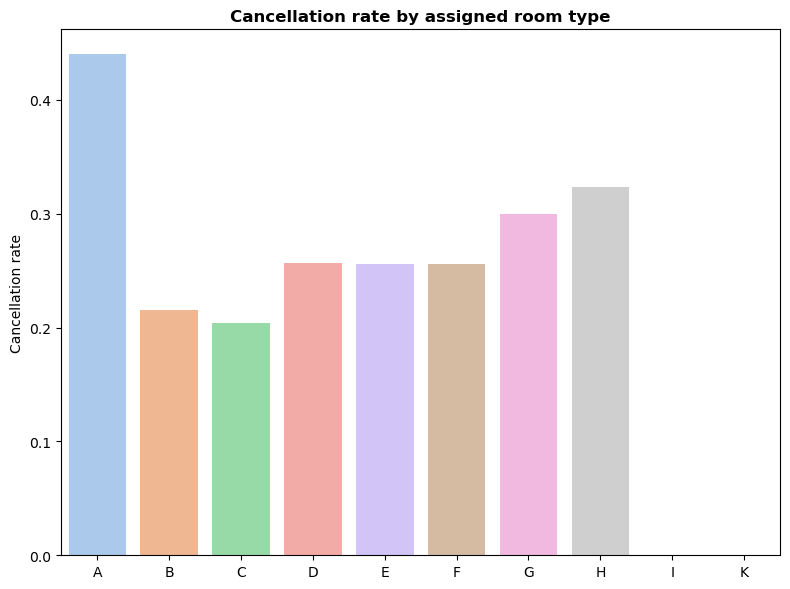

In [144]:
# Cancellation rate by assigned room type
plt.figure(figsize=(8, 6))
cancellation_by_room = booking.groupby('assigned_room_type')['canceled'].mean().reset_index().sort_values('assigned_room_type', ascending=True)
ax = sns.barplot(data=cancellation_by_room, x='assigned_room_type', y='canceled', hue='assigned_room_type', palette='pastel', legend=False)
ax.set_title("Cancellation rate by assigned room type", fontsize=12, fontweight='bold')
ax.set_xlabel("")
ax.set_ylabel("Cancellation rate")
plt.tight_layout()
plt.show()

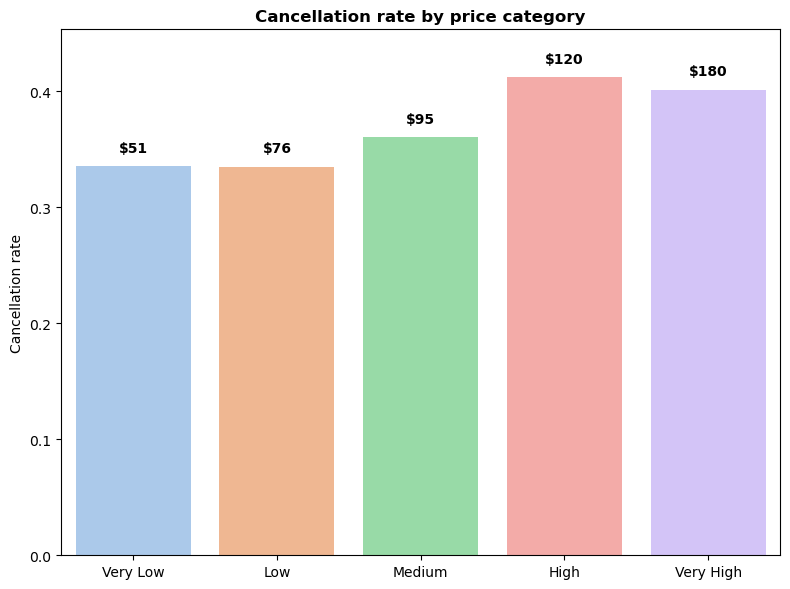

In [167]:
# Cancellation rate by price category
plt.figure(figsize=(8, 6))
cancellation_by_price = booking.copy()
cancellation_by_price['adr_bin'] = pd.qcut(cancellation_by_price['adr'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
cancellation_rate_price = cancellation_by_price.groupby('adr_bin', observed=False).agg({'canceled': 'mean', 'adr': 'mean'}).reset_index()
ax = sns.barplot(data=cancellation_rate_price, x='adr_bin', y='canceled', hue='adr_bin', palette='pastel', legend=False)
for i, p in enumerate(ax.patches):
    avg_price = cancellation_rate_price.iloc[i]['adr']
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.01, f"${avg_price:.0f}", ha='center', va='bottom', fontsize=10, fontweight='bold')
ax.set_title("Cancellation rate by price category", fontsize=12, fontweight='bold')
ax.set_xlabel("")
ax.set_ylabel("Cancellation rate")
ax.set_ylim(0, cancellation_rate_price['canceled'].max() * 1.1)
plt.tight_layout()
plt.show()

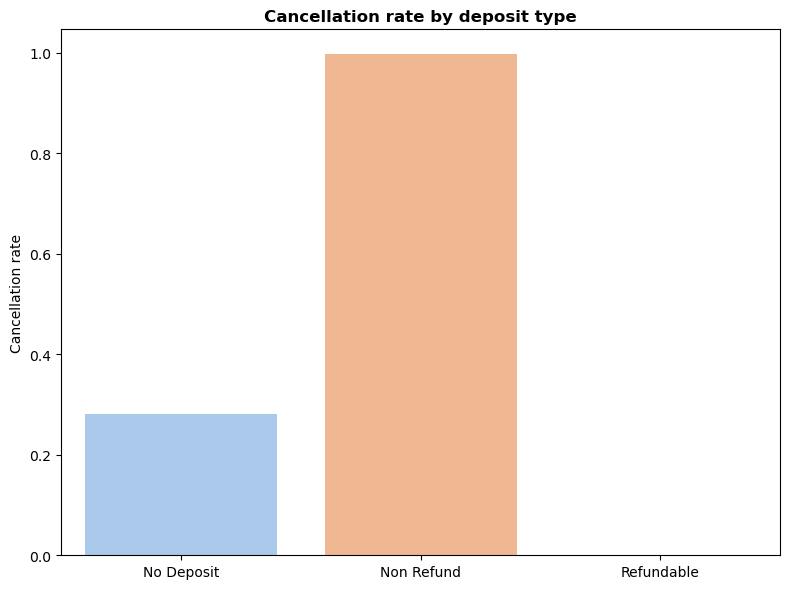

In [146]:
# Cancellation rate by deposit type
plt.figure(figsize=(8, 6))
cancellation_by_deposit = booking.groupby('deposit_type')['canceled'].mean().reset_index()
ax = sns.barplot(data=cancellation_by_deposit, x='deposit_type', y='canceled', hue='deposit_type', palette='pastel', legend=False)
ax.set_title("Cancellation rate by deposit type", fontsize=12, fontweight='bold')
ax.set_xlabel("")
ax.set_ylabel("Cancellation rate")
plt.tight_layout()
plt.show()

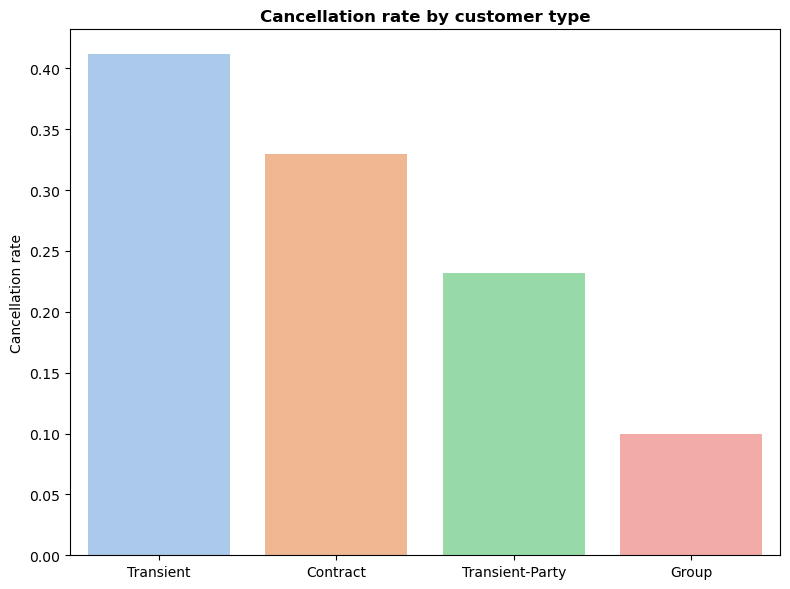

In [170]:
# Cancellation rate by customer type
plt.figure(figsize=(8, 6))
cancellation_by_customer = booking.groupby('customer_type')['canceled'].mean().reset_index().sort_values('canceled', ascending=False)
ax = sns.barplot(data=cancellation_by_customer, x='customer_type', y='canceled', hue='customer_type', palette='pastel', legend=False)
ax.set_title("Cancellation rate by customer type", fontsize=12, fontweight='bold')
ax.set_xlabel("")
ax.set_ylabel("Cancellation rate")
plt.tight_layout()
plt.show()

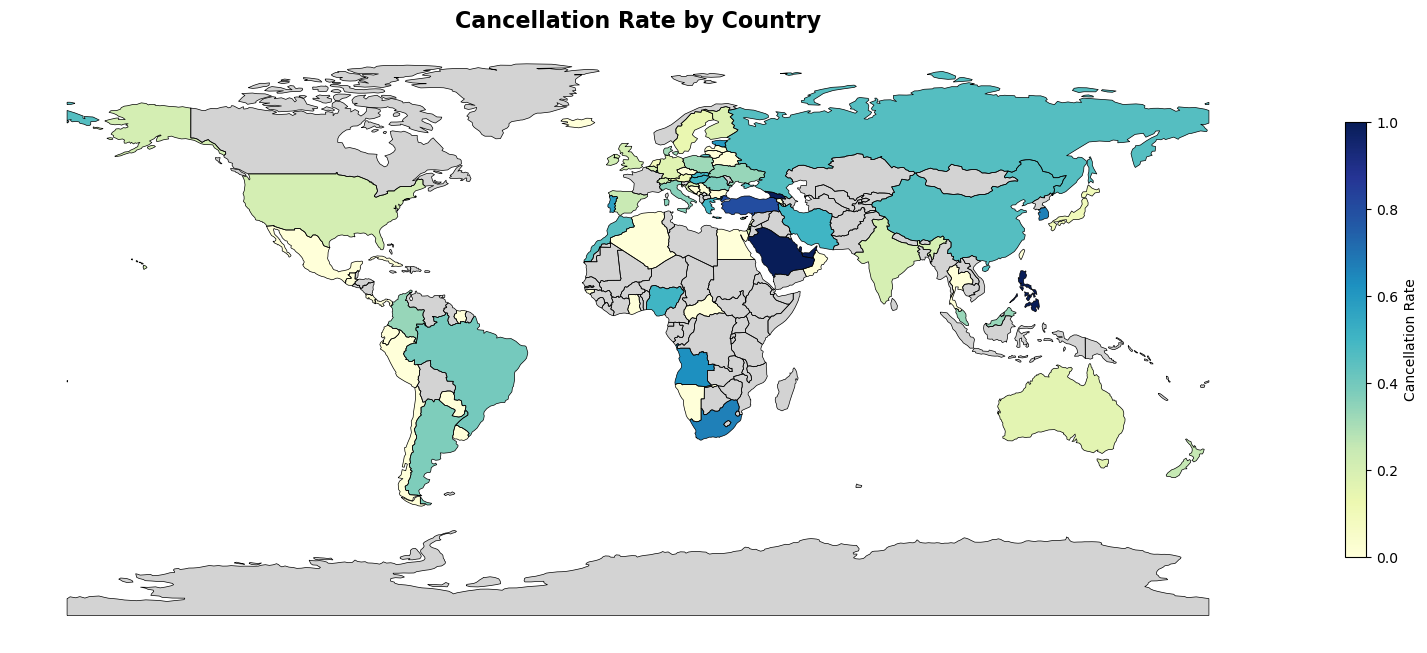

In [148]:
# Cancellation rate by country - Map visualization
import geopandas as gpd

# Get world map data from Natural Earth
world = gpd.read_file('https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip')

# Calculate cancellation rate by country
cancellation_by_country = booking.groupby('country')['canceled'].mean().reset_index()
cancellation_by_country.columns = ['iso_a3', 'cancellation_rate']

# Merge with world map (using ISO_A3 column from Natural Earth data)
world_cancel = world.merge(cancellation_by_country, left_on='ISO_A3', right_on='iso_a3', how='left')

# Create the map
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
world_cancel.boundary.plot(ax=ax, linewidth=0.5, color='black')
world_cancel.plot(
    column='cancellation_rate',
    ax=ax,
    legend=True,
    cmap='YlGnBu',
    missing_kwds={'color': 'lightgrey', 'label': 'No data'},
    legend_kwds={'label': 'Cancellation Rate', 'orientation': 'vertical', 'shrink': 0.5}
)
ax.set_title('Cancellation Rate by Country', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

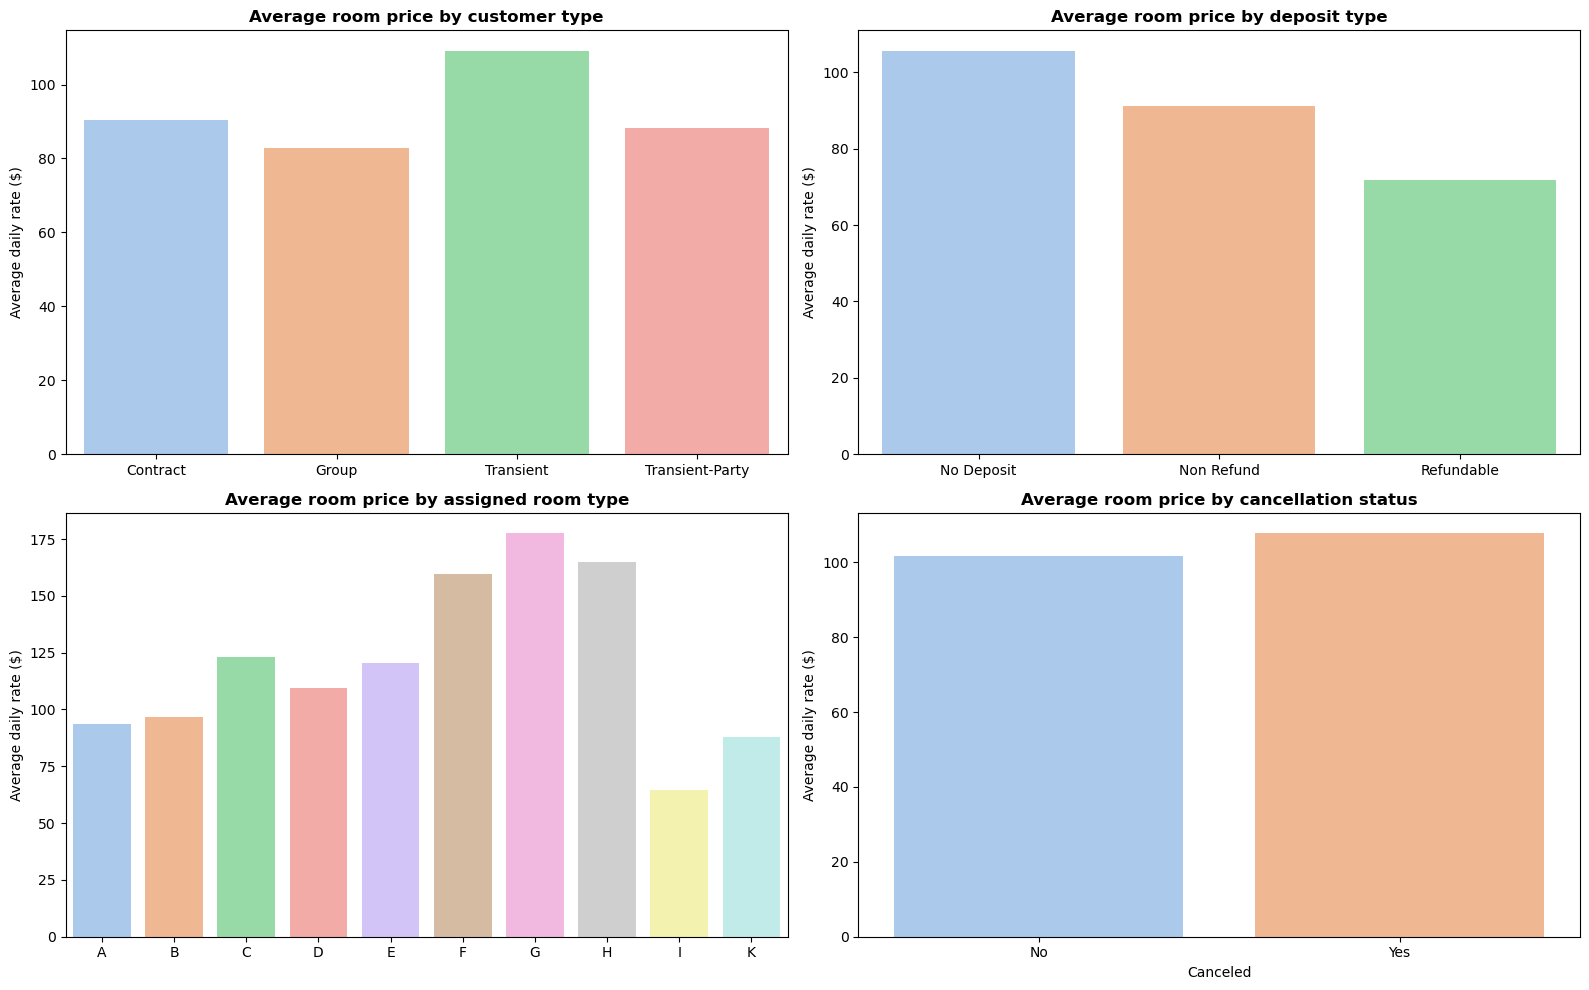

In [149]:
# Average room price by categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

# 1. Customer type
price_by_customer = booking.groupby('customer_type')['adr'].mean().reset_index()
sns.barplot(data=price_by_customer, x='customer_type', y='adr', hue='customer_type', palette='pastel', legend=False, ax=axes[0])
axes[0].set_title("Average room price by customer type", fontsize=12, fontweight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("Average daily rate ($)")

# 2. Deposit type
price_by_deposit = booking.groupby('deposit_type')['adr'].mean().reset_index()
sns.barplot(data=price_by_deposit, x='deposit_type', y='adr', hue='deposit_type', palette='pastel', legend=False, ax=axes[1])
axes[1].set_title("Average room price by deposit type", fontsize=12, fontweight='bold')
axes[1].set_xlabel("")
axes[1].set_ylabel("Average daily rate ($)")

# 3. Assigned room type
price_by_room = booking.groupby('assigned_room_type')['adr'].mean().reset_index().sort_values('assigned_room_type', ascending=True)
sns.barplot(data=price_by_room, x='assigned_room_type', y='adr', hue='assigned_room_type', palette='pastel', legend=False, ax=axes[2])
axes[2].set_title("Average room price by assigned room type", fontsize=12, fontweight='bold')
axes[2].set_xlabel("")
axes[2].set_ylabel("Average daily rate ($)")

# 3. Cancellation status
price_by_cancel = booking.groupby('canceled')['adr'].mean().reset_index()
price_by_cancel['canceled'] = price_by_cancel['canceled'].map({0: 'No', 1: 'Yes'})
sns.barplot(data=price_by_cancel, x='canceled', y='adr', hue='canceled', palette='pastel', legend=False, ax=axes[3])
axes[3].set_title("Average room price by cancellation status", fontsize=12, fontweight='bold')
axes[3].set_xlabel("Canceled")
axes[3].set_ylabel("Average daily rate ($)")



plt.tight_layout()
plt.show()

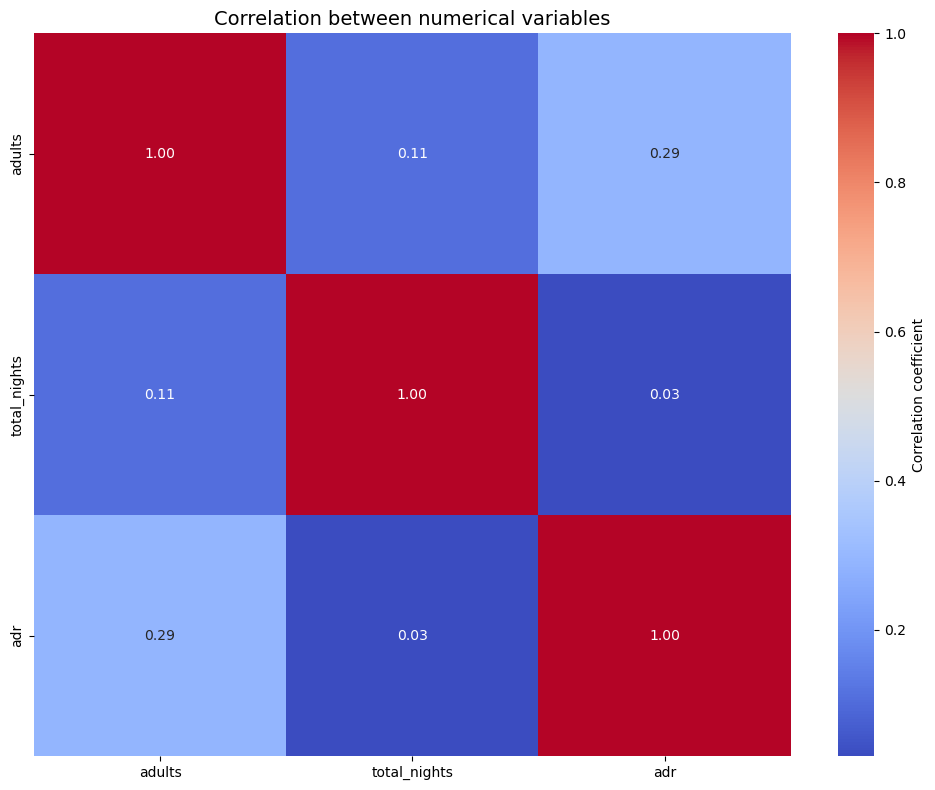

In [150]:
# Heatmap of correlation between numerical variables
plt.figure(figsize=(10, 8))
corr = booking[num_vars].corr()
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation coefficient'}
)
plt.title("Correlation between numerical variables", fontsize=14)
plt.tight_layout()

# Part 4: Association between categorical variables and cancellation

In [151]:
# Chi-square test for categorical variables
from scipy.stats import chi2_contingency

cat_vars = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'customer_type', 'deposit_type', 'reserved_room_type', 'assigned_room_type']

chi_square_results = []

for var in cat_vars:
    # Create contingency table
    contingency_table = pd.crosstab(booking[var], booking['canceled'])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate Cramér's V (effect size)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape[0], contingency_table.shape[1]) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    
    chi_square_results.append({
        'Variable': var,
        'Chi-square': chi2,
        'p-value': p_value,
        "Cramér's V": cramers_v,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

# Create DataFrame and sort by Cramér's V
chi_square_df = pd.DataFrame(chi_square_results).sort_values("Cramér's V", ascending=False)

print("Chi-square test results for categorical variables vs Cancellation")
print("=" * 80)
print("\nCramér's V interpretation:")
print("  0.00 - 0.10: Negligible association")
print("  0.10 - 0.30: Weak association")
print("  0.30 - 0.50: Moderate association")
print("  > 0.50: Strong association")
print("\n")

display(chi_square_df.style.format({
    'Chi-square': '{:.2f}',
    'p-value': '{:.2e}',
    "Cramér's V": '{:.3f}'
}).background_gradient(subset=["Cramér's V"], cmap='YlOrRd'))

Chi-square test results for categorical variables vs Cancellation

Cramér's V interpretation:
  0.00 - 0.10: Negligible association
  0.10 - 0.30: Weak association
  0.30 - 0.50: Moderate association
  > 0.50: Strong association




,Variable,Chi-square,p-value,Cramér's V,Significant
5,deposit_type,1159.40,1.74e-252,0.486,Yes
2,market_segment,322.15,1.46e-66,0.256,Yes
7,assigned_room_type,182.00,1.94e-34,0.192,Yes
3,distribution_channel,170.50,9.92e-37,0.186,Yes
4,customer_type,121.07,4.53e-26,0.157,Yes
0,hotel,96.91,7.24e-23,0.140,Yes
6,reserved_room_type,20.10,5.36e-03,0.064,Yes
1,meal,14.95,1.86e-03,0.055,Yes


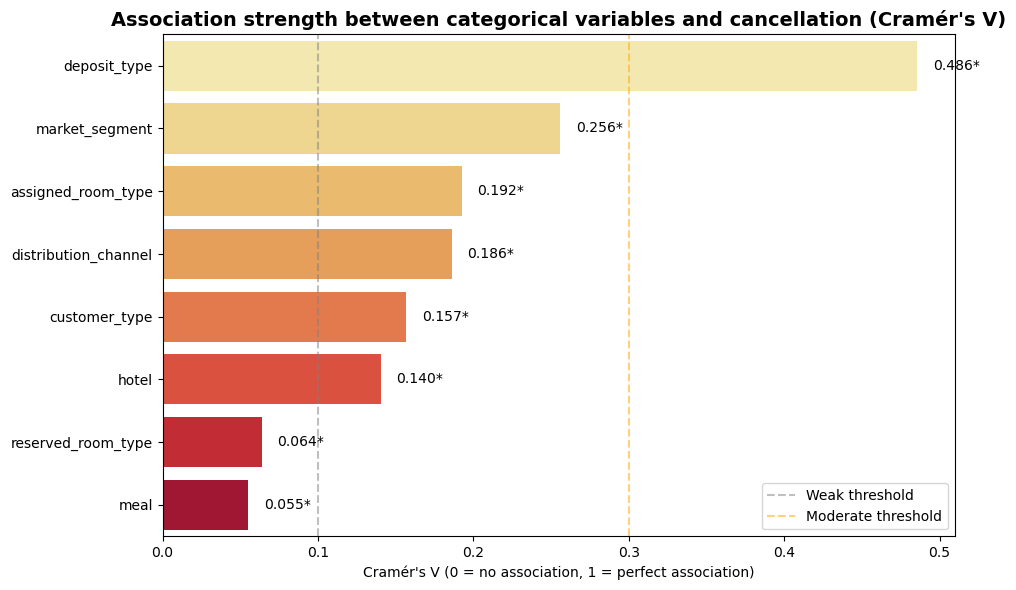

In [152]:
# Visualization of Cramér's V for categorical variables
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=chi_square_df,
    x="Cramér's V",
    y='Variable',
    hue='Variable',
    palette='YlOrRd',
    legend=False
)

# Add value labels on bars
for i, (v, sig) in enumerate(zip(chi_square_df["Cramér's V"], chi_square_df['Significant'])):
    label = f"{v:.3f}{'*' if sig == 'Yes' else ''}"
    ax.text(v + 0.01, i, label, va='center', fontsize=10)

plt.title("Association strength between categorical variables and cancellation (Cramér's V)", fontsize=14, fontweight='bold')
plt.xlabel("Cramér's V (0 = no association, 1 = perfect association)")
plt.ylabel("")
plt.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5, label='Weak threshold')
plt.axvline(x=0.3, color='orange', linestyle='--', alpha=0.5, label='Moderate threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Part 5: Machine Learning: Predicting cancellation with XGBoost

In [153]:
# Data preparation for machine learning
# Note: If you encounter import errors, you may need to reinstall scikit-learn:
# conda install -c conda-forge scikit-learn --force-reinstall

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Select features for the model
# Exclude: canceled (target), arrival_date, departure_date, month_num (derived), country (too many categories)
features_to_use = [
    col for col in [
        'hotel', 'arrival_date_week_number', 'arrival_date_day_of_month',
        'stays_in_weekend_nights', 'stays_in_week_nights', 'adults',
        'meal', 'market_segment', 'distribution_channel',
        'reserved_room_type', 'assigned_room_type', 'booking_changes', 
        'deposit_type', 'customer_type', 'adr', 
        'required_car_parking_spaces', 'total_of_special_requests',
        'arrival_date_month', 'total_nights'
    ] if col in booking.columns
]

print(f"Features selected: {len(features_to_use)}")

# Create a copy of the data
ml_data = booking[features_to_use + ['canceled']].copy()

# Encode categorical variables
categorical_cols = ml_data.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    ml_data[col] = le.fit_transform(ml_data[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = ml_data.drop('canceled', axis=1)
y = ml_data['canceled']

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data preparation complete")
print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Number of features: {X.shape[1]}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Features selected: 19
Data preparation complete
Training set size: 3934 samples
Test set size: 984 samples
Number of features: 19

Class distribution in training set:
canceled
0    0.631418
1    0.368582
Name: proportion, dtype: float64


In [154]:
# Hyperparameter optimization using GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize base model
xgb_base = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Use best model
xgb_model = grid_search.best_estimator_

print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

Best ROC-AUC: 0.8617
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}


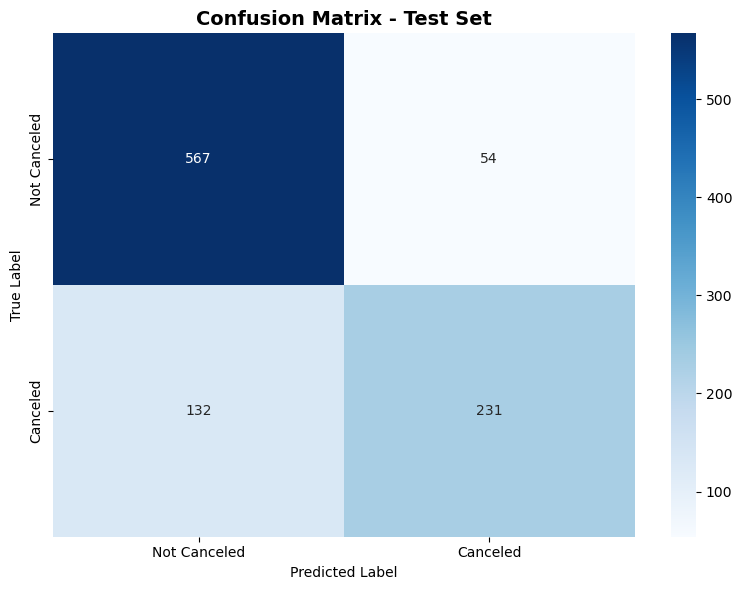

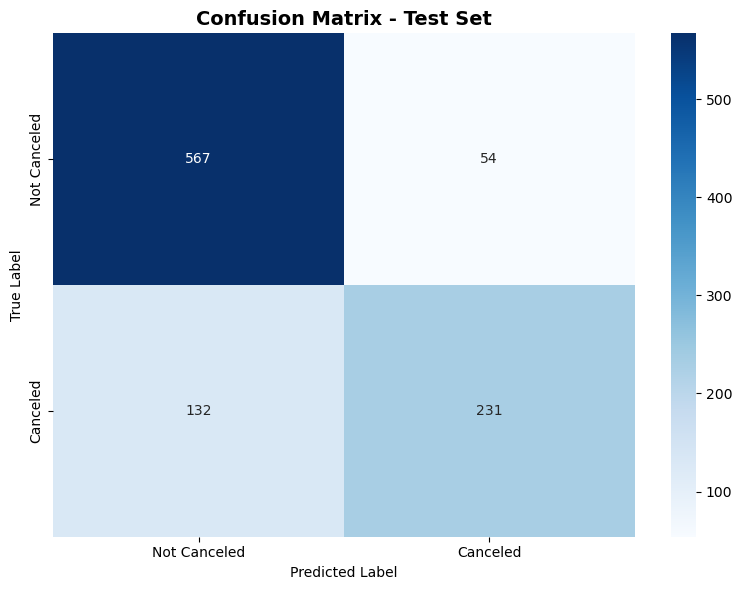

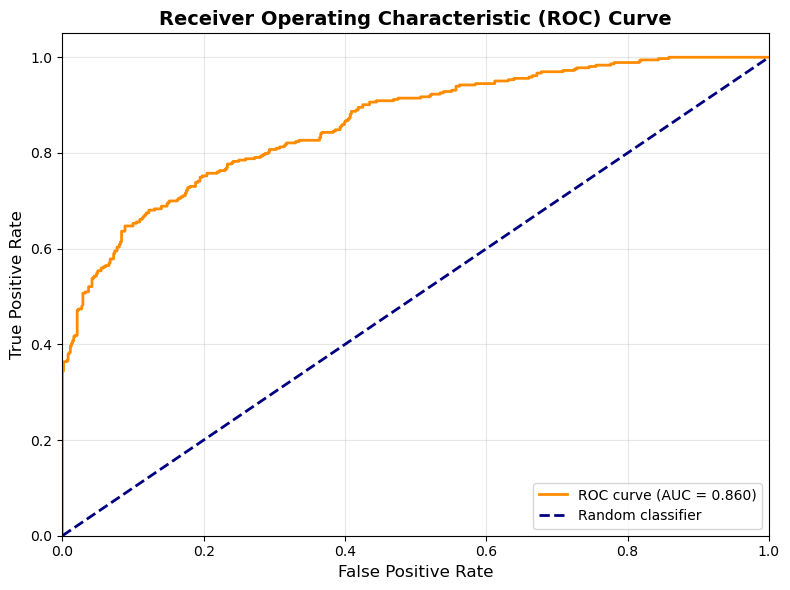

In [155]:
# Train final model and evaluate on test set
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Make predictions on test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Canceled', 'Canceled'],
            yticklabels=['Not Canceled', 'Canceled'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

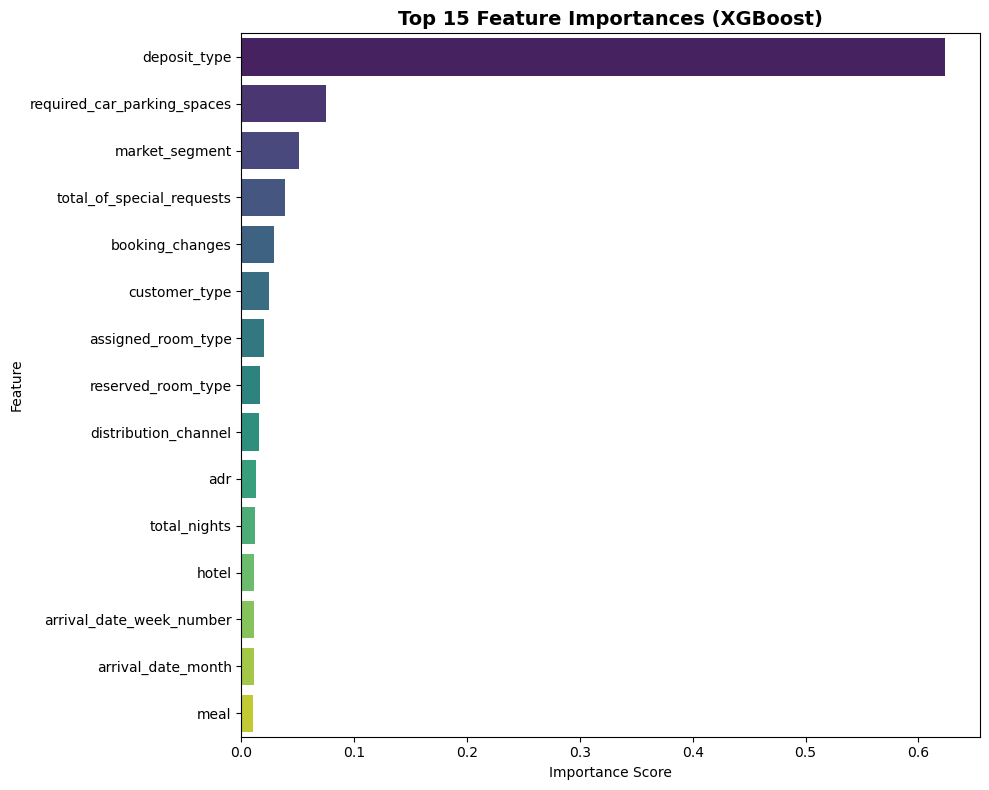

In [156]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()